# Waterfall plot

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.logreg_classifier import (
    antilogit_classifier_score,
    z_score,
)
from src.postprocessing import generate_waterfall_plot

In [3]:
### Reading csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
# setting index row name to the gene id
raw_data = raw_data.set_index("gene_id")

In [4]:
# Loading sheet 0, which contains the clinical diagnoses
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)
pathos = pathos[~pathos.loc[:, "Isolate ID"].isna()]
pathos = pathos.astype({"Isolate ID": "int"})
pathos = pathos.set_index("Isolate ID")

In [5]:
# Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
patients_df = patients_df.filter(regex=r"^\d+")

In [6]:
# group columns by patient id
grouped_cols = patients_df.columns.str.split("-").str[0]

# group columns by patient id and r1/r2 suffixes
grouped = patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)

/tmp/ipykernel_598359/1708168721.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [7]:
# Computing and storing zscores
means, stds = patients_df.mean(axis=1), patients_df.iloc[:, :-1].std(axis=1)
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [8]:
threshold = 0.85

In [9]:
probs = antilogit_classifier_score(z_scores_df.T @ coefficients)
probs_series = pd.Series(index=patients_df.columns, data=probs)

In [10]:
color_labels = pd.Series(index=probs_series.index, data=np.zeros(len(probs_series.index)))
for val in probs_series.index:
    if pathos.loc[int(val), "Disease"] == "AD":
        color_labels.loc[val] = 1

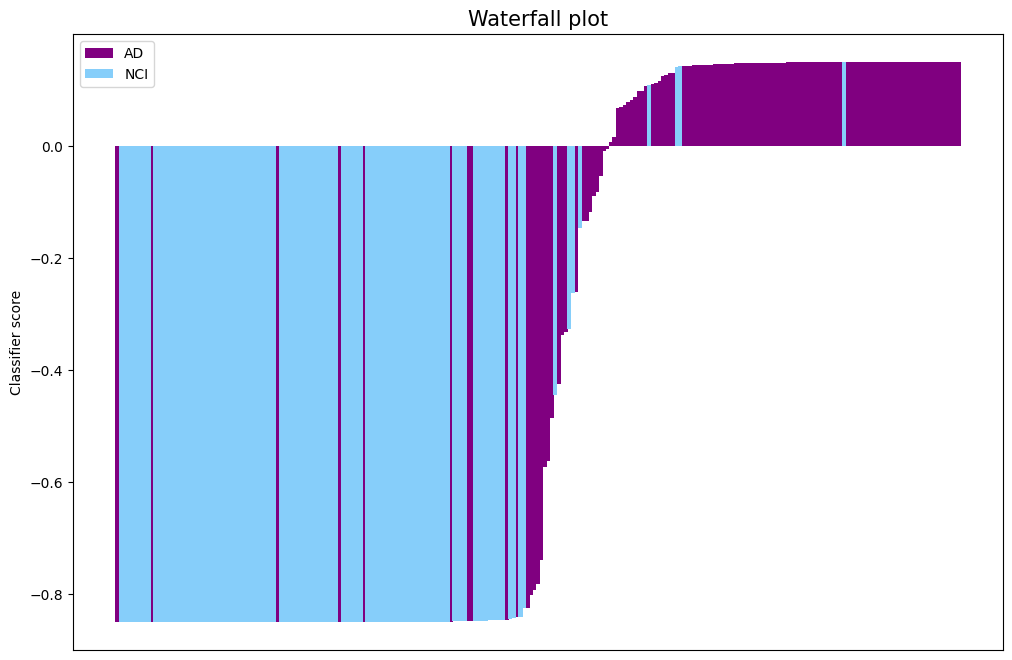

In [12]:
generate_waterfall_plot(threshold=threshold, 
                        probs=probs_series, 
                        color_labels_data=color_labels, 
                        labels={0: "NCI", 1: "AD"},
                        colors=["#800080", "#86cefa"],
                        title="Waterfall plot")